In [1]:
# Imports
import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%dotenv

import os
from collections import Counter

from graphdatascience import GraphDataScience
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch_geometric import seed_everything
from torch_geometric.data import HeteroData, Data
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.utils import to_networkx, homophily, subgraph
import torch_geometric.transforms as T
import torch.nn.functional as F

/home/ec2-user/miniconda3/envs/rnalab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Config

NEO4J_URI = os.environ.get('NEO4J_URI')
NEO4J_USER = os.environ.get('NEO4J_USER')
NEO4J_PASSWORD = os.environ.get('NEO4J_PASSWORD')

DATA_DIR = '/mnt/graphdata/lpa/'
FEATURES_DIR = '/mnt/graphdata/features/community'

RANDOM_SEED = 42

seed_everything(RANDOM_SEED)

In [3]:
# Db helpers

def get_gds_client():
    return GraphDataScience(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def query_gds(query):
    client = get_gds_client()
    return client.run_cypher(query)

In [5]:
q = '''
    MATCH (a:SOTU)
    WHERE NOT (a)-[:SEQUENCE_ALIGNMENT]-(:SOTU)
    RETURN 
        id(a) as nodeId,
        a.sotu as sotu,
        a.taxGenus as taxGenus,
        a.taxFamily as taxFamily,
        a.taxOrder as taxOrder,
        a.taxKingdom as taxKingdom,
        a.taxSpecies as taxSpecies
    '''

df = query_gds(q)
print(df)

         nodeId      sotu        taxGenus         taxFamily         taxOrder  \
0       7697028     u1529            None              None             None   
1       7697877     u1734            None              None             None   
2       7698120     u1819       Mimivirus       Mimiviridae    Imitervirales   
3       7707444     u5194            None       Benyviridae    Hepelivirales   
4       7708627     u5902            None              None             None   
...         ...       ...             ...               ...              ...   
367061  8755843  u1075439    Andhasavirus      Fiersviridae     Norzivirales   
367062  8755846  u1075447            None              None             None   
367063  8755849  u1075450  Picobirnavirus  Picobirnaviridae     Durnavirales   
367064  8755850  u1075453            None      Narnaviridae   Wolframvirales   
367065  8755851  u1075455            None    Endornaviridae  Martellivirales   

       taxKingdom                      

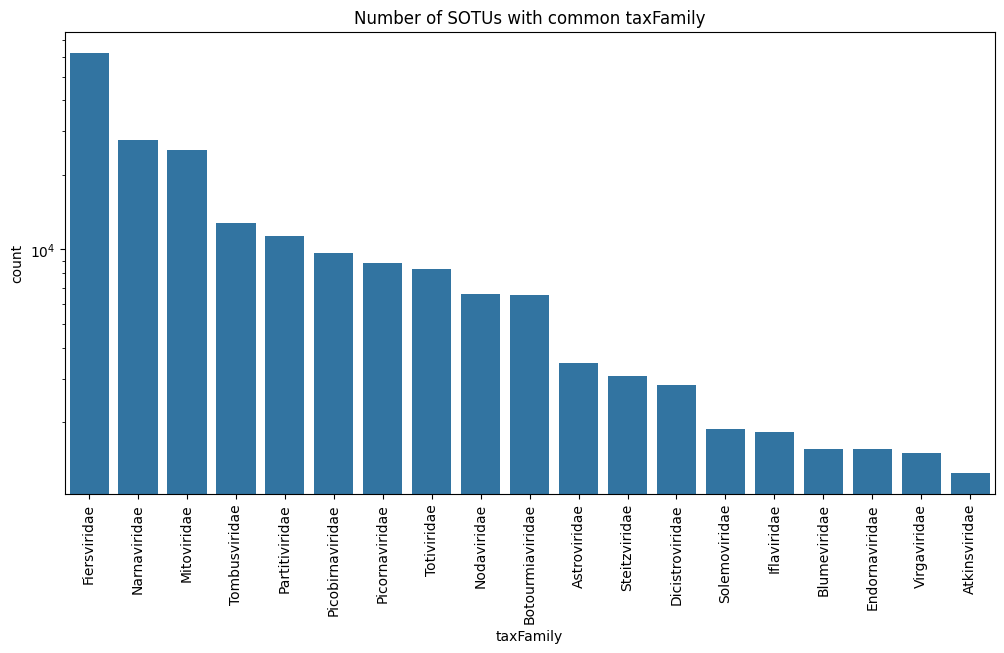

In [17]:
#  count number of sotus with common rank
rank = 'taxFamily'

genus_counts = Counter(df[rank])
genus_counts = pd.DataFrame.from_dict(genus_counts, orient='index').reset_index()
genus_counts.columns = [rank, 'count']
genus_counts = genus_counts.sort_values('count', ascending=False)
genus_counts = genus_counts[genus_counts['count'] > 1]
# plot
# top 20
genus_counts_plot = genus_counts.head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=rank, y='count', data=genus_counts_plot)
plt.xticks(rotation=90)
plt.title(f'Number of SOTUs with common {rank}')
# log scale
plt.yscale('log')
plt.show()

In [ ]:
# Create pyg graph of sotu - taxon 

class LabelEncoder(object):
    # The 'LabelEncoder' splits the raw column strings by 'sep' and converts
    # individual elements to categorical labels.
    def __init__(self, sep=',', is_tensor=False, mapping=None):
        self.sep = sep
        self.is_tensor = is_tensor
        self.mapping = mapping

    def __call__(self, df):
        mapping = self.mapping
        if self.is_tensor:
            if not mapping:
                labels = set(
                    label for col in df.values
                    for label in col.split(self.sep)
                )
                mapping = {label: i for i, label in enumerate(labels)}
            x = torch.zeros(len(df), len(mapping))
            for i, col in enumerate(df.values):
                for label in col.split(self.sep):
                    x[i, mapping[label]] = 1
            return x
        if not mapping:
            labels = df[df.columns[0]].unique()
            mapping = {label: i for i, label in enumerate(labels)}
        return df.replace(mapping)
    

def create_pyg_graph(df):
    # Create a heterogeneous graph
    data = HeteroData()

    # TODO: Add nodes to the graph

    return data